In [1]:
# %% All below code from Callum's path patching library
# %%

import torch as t
from torch import Tensor
from typing import Optional, Union, Dict, Callable, Optional, List, Tuple
from typing_extensions import Literal
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint
import transformer_lens.utils as utils
import itertools
from functools import partial
from tqdm.auto import tqdm
from jaxtyping import Float, Int
from collections import defaultdict
import einops
import re

# %%

_SeqPos = Optional[Int[Tensor, "batch pos"]]
SeqPos = Optional[Union[int, List[int], Int[Tensor, "batch *pos"]]]
IterSeqPos = Union[SeqPos, Literal["each"]]

def relevant_names_filter(name: str):
    '''Defining this so I don't have to use such a big cache. It contains all the names I'll need for any path patching.'''
    return any([name.endswith(s) for s in [
        "z", "resid_pre", "resid_mid", "resid_post", "pre", "post", "_input", "q", "k", "v", "attn_out", "mlp_out"
    ]])

def hook_fn_generic_patching(activation: Float[Tensor, "..."], hook: HookPoint, cache: ActivationCache) -> Float[Tensor, "..."]:
    '''Patches entire tensor of activations, from corresponding values in cache.'''
    activation[:] = cache[hook.name][:]
    return activation

def hook_fn_generic_caching(activation: Float[Tensor, "..."], hook: HookPoint, name: str = "activation") -> Float[Tensor, "..."]:
    '''Stores activations in hook context.'''
    hook.ctx[name] = activation
    return activation

def hook_fn_generic_patching_from_context(activation: Float[Tensor, "..."], hook: HookPoint, name: str = "activation", add: bool = False) -> Float[Tensor, "..."]:
    '''Patches activations from hook context, if they are there.'''
    if name in hook.ctx:
        if add:
            activation = activation + hook.ctx[name]
        else:
            activation[:] = hook.ctx[name][:]
    return activation

def get_hook_name_filter(model: HookedTransformer):
    # TODO - this seems dumb, should it be fixed in TL? Add a pull request for it?
    '''
    Helper function which returns a hook names filter function.

    I defined this because just using the hook names filter `lambda name: True` will throw an error whenever the model doesn't use attn results
    or split qkv input (it might try to add a hook where none exists). So this function just checks if the model uses attn results or split qkv input,
    and if it doesn't, then it only adds hooks for the other nodes.
    '''
    def name_filter(name):
        if name.endswith("_result") and (not model.cfg.use_attn_result):
            return False
        elif any([name.endswith(f"{c}_input") for c in "qkv"]) and (not model.cfg.use_split_qkv_input):
            return False
        elif any([name.endswith(f"{c}_normalized_input") for c in "qkv"]) and (not model.cfg.use_split_qkv_normalized_input):
            return False
        elif name.endswith("hook)tokens") and (not model.cfg.use_hook_tokens):
            return False
        return True

    return name_filter


class Node:
    '''
    Returns a node in a nice way, i.e. without requiring messy dicts.

    This class contains the following:
        Convenient ways to define nodes (see examples below)
        Error checking (making sure you don't define nodes incorrectly)
        Methods to return hook functions for stuff like patching

    Arguments:
        node_name
            Can be the full node name string, or just the node name (e.g. "q" or "resid_pre")
        layer
            If node_name is just abbrev, you can specify the layer here, and the full node name
            will be returned for you using `utils.get_act_name` (same syntax as the cache uses).
        seq_pos
            If this is None, we patch at all sequence positions.
            If this is not None, it's treated as a list of sequence positions over elements in our batch. It can either
            be an int or scalar tensor (then we patch at that seq pos for all elems in our batch), or a list/tensor with
            first dimension equal to batch size (then we patch at those seq pos for each elem in our batch). In this latter
            case, it can be either 1D (one seq pos per sequence) or 2D (a list of seq pos for each sequence).

    Examples of how we can specify a node:
        Node("blocks.1.attn.hook_attn_scores")   # specify with entire hook name
        Node("q", 0)                             # syntax like how we index cache
        Node("q", 0, head=1)                     # syntax like how we index cache (plus specifying head)
        Node("pre", 5, neuron=1337)             # like utils.get_act_name("resid_pre", 5), at sequence positions [3, 4]
    '''
    def __init__(
        self, 
        node_name, 
        layer: Optional[int] = None,
        head: Optional[int] = None,
        neuron: Optional[int] = None,
        seq_pos: SeqPos = None,
    ):
        if layer is not None: assert layer >= 0, "Doesn't accept negative layers."

        if "hook_" in node_name:
            self.component_name = node_name.split("hook_")[-1]
            self.layer = re.search("\.(\d)\.", node_name)
            if self.layer is not None: self.layer = int(self.layer.group(1))
        else:
            self.component_name = node_name
            self.layer = layer

        if head is not None: assert isinstance(head, int), f"head should be an int, not {type(head)}"
        if neuron is not None: assert isinstance(neuron, int), f"neuron should be an int, not {type(neuron)}"
        self.head = head
        self.neuron = neuron
        self.seq_pos = seq_pos

        # Check if head dimension is appropriate
        if not any(name in self.activation_name for name in ["q", "k", "v", "z", "pattern"]):
            assert self.head is None, f"Can't specify `head` for activation {self.activation_name}."

        # Check if neuron dimension is appropriate
        if not any(name in self.activation_name for name in ["pre", "post"]):
            assert self.neuron is None, f"Can't specify `neuron` for activation {self.activation_name}."


    @property
    def activation_name(self):
        return utils.get_act_name(self.component_name, layer=self.layer)
    

    def get_posn(self):
        '''
        Gives a number representing the position of this node in the model.

        Used to check whether a node comes before another one, because the operation:
            orig_receiver_input <- orig_receiver_input + (new_sender_output - orig_sender_output)
        shouldn't be done if receiver comes after sender in the model.

        The function is pretty janky. It gets an int for layer, plus a float in the range (0, 1) for position within
        a layer, that way the sum of these two will always tell you whether one node comes before the other.
        '''
        if self.layer is None:
            layer = -1 if self.component_name in ["embed", "pos_embed", "tokens"] else 10e5
        else:
            layer = self.layer
        
        if "resid_pre" in self.activation_name:
            within_layer = 0.0
        elif ".ln1." in self.activation_name:
            within_layer = 0.1
        elif ".attn." in self.activation_name or any([f"{s}_input" in self.activation_name for s in "qkv"]):
            within_layer = 0.2
        elif "attn_out" in self.activation_name:
            within_layer = 0.3
        elif "resid_mid" in self.activation_name:
            within_layer = 0.4
        elif ".ln2." in self.activation_name:
            within_layer = 0.5
        elif ".mlp." in self.activation_name or "mlp_in" in self.activation_name:
            within_layer = 0.6
        elif "mlp_out" in self.activation_name:
            within_layer = 0.7
        elif "resid_post" in self.activation_name:
            # resid_post in a layer is the same as resid_pre in the next layer
            within_layer = 1.0
        else:
            raise Exception("Error in function - haven't yet added a case for this name.")
            
        return layer + within_layer
                
    def __ge__(self, other: "Node"):
        return self.get_posn() >= other.get_posn()
    
    def __gt__(self, other: "Node"):
        return self.get_posn() > other.get_posn()


    def check_sender(self, model: HookedTransformer) -> List["Node"]:
        '''
        Raises an error if this isn't a valid sender node.

        The valid list is quite restrictive, because this helps make sure edge cases are avoided where possible.
        '''
        # We only do individual sequence position patches for activation patching, not path patching
        assert self.seq_pos is None, "Error: can't specify `seq_pos` for path patching. You should use the `seq_pos` argument in the `path_patch` function."

        # Make sure it's actually real
        assert self.activation_name in model.hook_dict.keys(), f"Error: node '{self.activation_name}' is not in the hook dictionary."

        # Do main validity check
        # TODO - allow "result", since there are use cases (e.g. if you're editing the new_cache directly)
        valid_sender_nodes = ["z", "attn_out", "post", "mlp_out", "resid_pre", "resid_post", "resid_mid"]
        assert self.component_name in valid_sender_nodes, f"Error: node '{self.component_name}' is not a valid sender node. Valid sender nodes are: {valid_sender_nodes}"

        return [self]

    
    def check_and_split_receiver(self, model: HookedTransformer) -> List["Node"]:
        '''
        Checks if this is a valid receiver node.

        We need to make sure it's not "attn_out" or "mlp_out" (because if it's a receiver then caching needs to happen before patching in step 2).
        But rather than raising an error in this case, we can just change the patching to be at "z" or "post" instead.

        Also splits the receiver node into multiple nodes if required, e.g. "pattern" becomes "q" and "k".
        '''
        # We only do individual sequence position patches for activation patching, not path patching
        assert self.seq_pos is None, "Error: can't specify `seq_pos` for path patching. You should use the `seq_pos` argument in the `path_patch` function."

        # Make sure it's actually real
        assert self.activation_name in model.hook_dict.keys(), f"Error: node '{self.activation_name}' is not in the hook dictionary."

        # Make specific substitution requests (i.e. "you tried X, instead you should do Y")
        assert self.component_name != "mlp_in", "Error: 'mlp_in' is not a valid sender node. Please use 'pre' for the output of attention heads (to select specific neurons, use the 'neuron' argument in the Node constructor)."

        # Do main validity check
        valid_receiver_nodes = ["q", "k", "v", "pattern", "q_input", "k_input", "v_input", "resid_pre", "resid_mid", "resid_post", "pre"]
        assert self.component_name in valid_receiver_nodes, f"Error: node '{self.component_name}' is not a valid receiver node. Valid receiver nodes are: {valid_receiver_nodes}"

        # If node name is "pattern", we want to split this into "q" and "k"
        # TODO - is this just bad? Maybe we never want to patch into pattern in this way?
        if self.component_name == "pattern":
            return [Node("q", layer=self.layer, head=self.head), Node("k", layer=self.layer, head=self.head)]
        else:
            return [self]


    def get_patching_hook_fn(self, cache: Union[str, ActivationCache], batch_indices: Union[slice, Int[Tensor, "batch pos"]], seq_pos_indices: Union[slice, Int[Tensor, "batch pos"]]) -> Callable:
        '''
        Returns a hook function for doing patching according to this node.

        This is used in 2 different ways:

            (A) In step 2 of the 3-step path patching algorithm, where we're patching the output
                of sender nodes from orig -> new cache. In this case, cache is an actual cache.

            (B) In step 3 of the 3-step path patching algorithm, where we're patching the input
                of receiver nodes with the values which were stored in context. In this case, cache
                is actually a string (the key in the hook.ctx dict).

        The key feature of this method is that it gives us a function which patches at specific sequence positions / heads / neurons. It doesn't just patch everywhere!
        '''
        def hook_fn(activations: Float[Tensor, "..."], hook: HookPoint) -> Float[Tensor, "..."]:
            # Define an index for slicing (by default slice(None), which is equivalent to [:])
            idx = [batch_indices, seq_pos_indices] + [slice(None) for _ in range(activations.ndim - 2)]

            # Check if we need to patch by head, and if so then check where the head dim is
            if self.head is not None:
                # Attn patterns are messy because its shape is (batch, head, seqQ, seqK) not (batch, seq, ...). In this case we assume seq_pos_indices refer to the query position.
                if "pattern" in hook.name or "score" in hook.name:
                    assert isinstance(seq_pos_indices, slice), "Can't patch attention patterns/scores at specific sequence positions (ambiguous whether this is query or key positions)."
                    idx = [slice(None) for _ in range(activations.ndim)]
                    idx[1] = self.head
                else:
                    idx[2] = self.head

            # Check if we need to patch by neuron, and if so then check where the neuron dim is
            if self.neuron is not None: idx[-1] = self.neuron

            # Now, patch the values in our activations tensor, and return the new activation values
            if isinstance(cache, str):
                new_activations = hook.ctx[cache]
            else:
                new_activations = cache[hook.name]
            
            activations[idx] = new_activations[idx]
            return activations

        return hook_fn

    
    def __repr__(self):
        head = "" if self.head is None else f", head={self.head}"
        neuron = "" if self.neuron is None else f", neuron={self.neuron}"
        return f"Node({self.activation_name}{head}{neuron})"



def product_with_args_kwargs(*args, **kwargs):
    '''
    Helper function which generates an iterable from args and kwargs.

    For example, running the following:
        product_with_args_kwargs([1, 2], ['a', 'b'], key1=[True, False], key2=["q", "k"])
    gives us a list of the following tuples:
        ((1, 'a'), {'key1', True, 'key2': 'q'})
        ((1, 'a'), {'key1', False})
        ((1, 'b'), ('key1', True))
        ...
        ((2, 'b'), {'key1', False, 'key2': 'k'})
    '''
    # Generate the product of args
    args_product = list(itertools.product(*args))
    
    # Generate the product of kwargs values
    kwargs_product = list(itertools.product(*kwargs.values()))
    
    # Combine args_product with each dict from kwargs_product
    result = []
    for args_values in args_product:
        for kwargs_values in kwargs_product:
            # Construct dict from keys and current values
            kwargs_dict = dict(zip(kwargs.keys(), kwargs_values))
            # Append the tuple with current args_values and kwargs_dict
            result.append((args_values, kwargs_dict))

    return result




# TODO - the way seq_pos is handled in this class is super janky. What's done in the __init__ vs the get_node_dict should be more cleanly separated. Do we even need anything in the init?

class IterNode:
    '''
    Class for defining a list of nodes.

    In other words, we specify a few arguments, and this thing gives us a list of Node objects.

    Args:
        nodes
            name of node (or list of componnet names) which we iterate over
        seq_pos
            Is `None` by default, but can also be `"each"`, or it can be specified as an int or list of ints.

    Examples:
        IterNode(node_names=["q", "k", "v"], seq_pos="each")
            - this is how we might iterate over receiver nodes
            - it'll give us a dict with keys ("q", "k", "v") and values = tensors of shape (seq_pos, layers, heads)
            - each element would be the result of patching from some fixed sender to a different receiver

        IterNode(node_names=["attn_out", "mlp_out", "resid_pre"])
            - this is how we might iterate over sender nodes
            - it'll give us a dict with keys ("attn_out", "mlp_out", "resid_pre") and values = 1D tensors of shape (layers,)

        IterNode(node_names="attn_out", seq_pos="each")
            - this is how we might iterate over sender nodes
            - it'll give us a tensor of shape (layers, seq_pos)

    Note:
        If you want to iterate over each attn head, use 'z' (or something with a head dim). If you want to get all heads simultaneously, use 'attn_out'.
        If you want to iterate over each neuron, use 'post'. If you want to get all heads simultaneously, use 'attn_out'.
    '''
    def __init__(
        self, 
        node_names: Union[str, List[str]], 
        seq_pos: IterSeqPos = None,
    ):
        self.seq_pos = seq_pos

        # Get node_names into a list, for consistency
        self.component_names = [node_names] if isinstance(node_names, str) else node_names

        # Figure out what the dimensions of the output will be (i.e. for our path patching iteration)
        self.shape_names = {}
        for node in self.component_names:
            # Everything has a "layer" dim
            self.shape_names[node] = ["layer"]
            # Add "seq_pos", if required
            if seq_pos == "each": self.shape_names[node].append("seq_pos")
            # Add "head" and "neuron", if required
            if node in ["q", "k", "v", "z", "pattern"]: self.shape_names[node].append("head")
            if node in ["pre", "post"]: self.shape_names[node].append("neuron")

        # Result:
        #   self.shape_names = {"z": ["layer", "seq_pos", "head"], "post": ["layer", "neuron"], ...}
        # where each value is the list of things we'll be iterating over.


    def get_node_dict(
        self, 
        model: HookedTransformer,
        tensor: Optional[Float[Tensor, "batch seq_pos d_vocab"]] = None
    ) -> Dict[str, List[Tuple[Tensor, Node]]]:
        '''
        This is how we get the actual list of nodes (i.e. `Node` objects) which we'll be iterating through, as well as the seq len (because
        this isn't stored in every node object).

        It will look like:
            {"z": [
                (seq_pos, Node(...)), 
                (seq_pos, Node(...)),
                ...
            ], 
            "post": [
                (seq_pos, Node(...))
                ...
            ]}
        where each value is a list of `Node` objects, and we'll path patch separately for each one of them.

        We need `model` and `tensor` to do it, because we need to know the shapes of the nodes (e.g. how many layers or sequence positions,
        etc). `tensor` is assumed to have first two dimensions (batch, seq_len).
        '''
        # Get a dict we can use to convert from shape names into actual shape values
        # We filter dict down, because we might not need all of these (e.g. we'll never need neurons and heads at the same time!)
        batch_size, seq_len = tensor.shape[:2]
        shape_values_all = {"seq_pos": seq_len, "layer": model.cfg.n_layers, "head": model.cfg.n_heads, "neuron": model.cfg.d_mlp}

        # Get a dictionary to store the nodes (i.e. this will be a list of `Node` objects for each node name)
        # Also, get dict to store the actual shape values for each node name
        self.nodes_dict = {}
        self.shape_values = {}

        # If iterating, get a list of sequence positions we'll be iterating over
        if self.seq_pos == "each":
            seq_pos_indices = list(einops.repeat(t.arange(seq_len), "s -> s b 1", b=batch_size))
        # If not iterating, then each node in the iteration has a fixed sequence length
        else:
            seq_pos_indices = [self.seq_pos]


        # Fill in self.shape_values with the actual values, and self.nodes_dict using itertools.product
        # Note, this is a bit messy (e.g. node name and layer are *args, but head/neuron/seq_pos are **kwargs)
        for node_name, shape_names in self.shape_names.items():
            
            shape_values_dict = {name: value for name, value in shape_values_all.items() if name in shape_names}
            shape_ranges = {name: range(value) for name, value in shape_values_dict.items() if name != "seq_pos"}

            self.shape_values[node_name] = shape_values_dict

            # Turn the ranges into a list of Node objects, using a fancy version of itertools.product
            # args are (seq_pos,), kwargs are all the non-seq_pos values (i.e. layer, head, neuron)
            shape_values_list = product_with_args_kwargs(seq_pos_indices, **shape_ranges)
            self.nodes_dict[node_name] = [(args[0], Node(node_name, **kwargs)) for args, kwargs in shape_values_list]

        return self.nodes_dict


def get_batch_and_seq_pos_indices(seq_pos, batch_size, seq_len):
    '''
    seq_pos can be given in four different forms:
        None             -> patch at all positions
        int              -> patch at this position for all sequences in batch
        list / 1D tensor -> this has shape (batch,) and the [i]-th elem is the position to patch for the i-th sequence in the batch
        2D tensor        -> this has shape (batch, pos) and the [i, :]-th elem are all the positions to patch for the i-th sequence
    
    This function returns batch_indices, seq_pos_indices as either slice(None)'s in the first case, or as 2D tensors in the other cases.

    In other words, if a tensor of activations had shape (batch_size, seq_len, ...), then you could index into it using:

        activations[batch_indices, seq_pos_indices]
    '''
    if seq_pos is None:
        seq_sub_pos_len = seq_len
        seq_pos_indices = slice(None)
        batch_indices = slice(None)
    else:
        if isinstance(seq_pos, int):
            seq_pos = [seq_pos for _ in range(batch_size)]
        if isinstance(seq_pos, list):
            seq_pos = t.tensor(seq_pos)
        if seq_pos.ndim == 1:
            seq_pos = seq_pos.unsqueeze(-1)
        assert (seq_pos.ndim == 2) and (seq_pos.shape[0] == batch_size) and (seq_pos.shape[1] <= seq_len) and (seq_pos.max() < seq_len), "Invalid 'seq_pos' argument."
        seq_sub_pos_len = seq_pos.shape[1]
        seq_pos_indices = seq_pos
        batch_indices = einops.repeat(t.arange(batch_size), "batch -> batch seq_sub_pos", seq_sub_pos=seq_sub_pos_len)
    
    return batch_indices, seq_pos_indices



def _path_patch_single(
    model: HookedTransformer,
    orig_input: Union[str, List[str], Int[Tensor, "batch pos"]],
    sender: Union[Node, List[Node]],
    receiver: Union[Node, List[Node]],
    patching_metric: Union[Callable, Literal["loss", "loss_per_token"]],
    orig_cache: ActivationCache,
    new_cache: ActivationCache,
    seq_pos: _SeqPos = None,
    apply_metric_to_cache: bool = False,
    names_filter_for_cache_metric: Optional[Callable] = None,
    direct_includes_mlps: bool = True,
) -> Float[Tensor, ""]:
    '''
    This function gets called by the main `path_patch` function, when direct_includes_mlps = False. It shouldn't be called directly by user.

    There are 2 options for how to treat MLPs - either MLPs are direct paths or they aren't.

    direct_includes_mlps = False
        This version is simpler. It doesn't treat MLPs as direct, so a "direct path" is just the skip connection from sender output -> receiver input.
        The algorithm works as follows:
            (1) Gather all activations on orig and new distributions.
            (2) Forward pass on orig input, with the following intervention:
                orig_receiver_input <- orig_receiver_input + sum_over_senders {new_sender_output - orig_sender_output}

    direct_includes_mlps = True
        This version is more complex. Step (2) can't happen in one forward pass, because the new value we patch the receivers to is a function of the MLP's nonlinear jiggery
        pokery. We split step (2) into 2 steps, one where we patch senders & compute what we'll be patching into the receivers, and one where we actually perform the receiver patching.
        The algorithm works as follows:
            (1) Gather all activations on orig and new distributions.
            (2) Run model on orig with sender nodes patched from new and all other nodes frozen. Cache the receiver nodes.
            (3) Run model on orig with receiver nodes patched from previously cached values.

    Although it seems from this like direct_includes_mlps=False is simpler, it's actually more complicated to implement in a way that doesn't use two forward passes, because there's
    a lot of bookkeeping to do to make sure we're adding the right diffs in the right places.

    A few small implementational notes:
        * seq_pos is either None (indicating all sequence positions) or a 2D array of shape (batch, seq_sub_pos). In this latter case, the [i, :]-th element contains the sequence positions
          we'll be patching at for the i-th element of the batch. The main path_patch function handles the conversion of seq_pos from ints to 2D tensors.
        * If one of the receiver nodes is 'pre', then we actually perform the 3-step algorithm rather than the 2-step algorithm. This is because there's no "mlp split input by neuron" in
          the same way as there's a "by head (and input type) split" for attention heads.
    '''
    # Call this at the start, just in case! This also clears context by default
    model.reset_hooks()

    # Turn the nodes into a list of nodes (for consistency)
    _sender_nodes = [sender] if isinstance(sender, Node) else sender
    _receiver_nodes = [receiver] if isinstance(receiver, Node) else receiver
    assert isinstance(_sender_nodes, list) and isinstance(_receiver_nodes, list)

    # Get slices for sequence position
    batch_size, seq_len = orig_cache["z", 0].shape[:2]
    batch_indices, seq_pos_indices = get_batch_and_seq_pos_indices(seq_pos, batch_size, seq_len)

    # Check the nodes are valid, and split them, e.g. Node(pattern) becomes [Node(q), Node(k)]
    sender_nodes: List[Node] = []
    receiver_nodes: List[Node] = []
    for node in _sender_nodes:
        sender_nodes.extend(node.check_sender(model))
    for node in _receiver_nodes:
        receiver_nodes.extend(node.check_and_split_receiver(model))
    

    if direct_includes_mlps or any([n.component_name == "pre" for n in receiver_nodes]):
        # Run model on orig with sender nodes patched from new and all other nodes frozen. Cache the receiver nodes.

        # We need to define three sets of hook functions: for freezing heads, for patching senders (which override freezing), and for caching receivers (before freezing)
        hooks_for_freezing = []
        hooks_for_caching_receivers = []
        hooks_for_patching_senders = []

        # Get all the hooks we need for freezing heads (and possibly MLPs)
        # (note that these are added at "z" and "post", because if they were added at "attn_out" or "mlp_out" then we might not be able to override them with the patching hooks)
        hooks_for_freezing.append((lambda name: name.endswith("z"), partial(hook_fn_generic_patching, cache=orig_cache)))
        if not direct_includes_mlps:
            hooks_for_freezing.append((lambda name: name.endswith("post"), partial(hook_fn_generic_patching, cache=orig_cache)))

        # Get all the hooks we need for patching heads (and possibly MLPs)
        for node in sender_nodes:
            hooks_for_patching_senders.append((node.activation_name, node.get_patching_hook_fn(new_cache, batch_indices, seq_pos_indices)))

        # Get all the hooks we need for caching receiver nodes
        for node in receiver_nodes:
            hooks_for_caching_receivers.append((node.activation_name, partial(hook_fn_generic_caching, name="receiver_activations")))

        # Now add all the hooks in order. Note that patching should override freezing, and caching should happen before both.
        model.run_with_hooks(
            orig_input,
            return_type=None,
            fwd_hooks=hooks_for_caching_receivers + hooks_for_freezing + hooks_for_patching_senders,
            clear_contexts=False # This is the default anyway, but just want to be sure!
        )
        # Result - we've now cached the receiver nodes (i.e. stored them in the appropriate hook contexts)


        # Lastly, we add the hooks for patching receivers (this is a bit different depending on our alg)
        for node in receiver_nodes:
            model.add_hook(
                node.activation_name,
                node.get_patching_hook_fn("receiver_activations", batch_indices, seq_pos_indices),
                level=1
            )


    else:
        # Calculate the (new_sender_output - orig_sender_output) for every sender, as something of shape d_model
        sender_diffs = {}
        for sender_node in sender_nodes:

            diff = new_cache[sender_node.activation_name] - orig_cache[sender_node.activation_name]
            diff = diff[batch_indices, seq_pos_indices]

            # If it's post neuron activations, we map through W_out (maybe just taking one neuron)
            if sender_node.component_name == "post":
                neuron_slice = slice(None) if sender_node.neuron is None else [sender_node.neuron]
                diff = einops.einsum(
                    diff[..., neuron_slice], model.W_out[sender_node.layer, neuron_slice],
                    "batch pos d_mlp, d_mlp d_model -> batch pos d_model"
                )
            # If it's the "z" part of attn heads, we map through W_O (maybe just taking one head)
            elif sender_node.component_name == "z":
                head_slice = slice(None) if sender_node.head is None else [sender_node.head]
                diff = einops.einsum(
                    diff[..., head_slice, :], model.W_O[sender_node.layer, head_slice],
                    "batch pos n_heads d_head, n_heads d_head d_model -> batch pos d_model"
                )
            # If not in these two cases, it's one of resid_pre/mid/post, or attn_out/mlp_out/result, and so should already be something with shape (batch, subseq_len, d_model)
            sender_diffs[sender_node] = diff


        # Calculate the sum_over_senders{new_sender_output-orig_sender_output} for every receiver, by taking all the senders before the receiver
        # We add this diff into the hook context, 
        for sender_node, diff in sender_diffs.items():

            for i, receiver_node in enumerate(receiver_nodes):
                
                # If there's no causal path from sender -> receiver, we skip
                if not (sender_node < receiver_node):
                    continue

                if receiver_node.component_name in ["q", "k", "v", "q_input", "k_input", "v_input"]:
                    assert model.cfg.use_split_qkv_input, "Direct patching (direct_includes_mlps=False) requires use_split_qkv_input=True. Please change your model config."
                    
                    # q/k/v should be converted into q_input/k_input/v_input
                    if receiver_node.component_name in ["q", "k", "v"]: 
                        receiver_node = Node(f"{receiver_node.component_name}_input", layer=receiver_node.layer, head=receiver_node.head)
                        receiver_nodes[i] = receiver_node

                # If this is the first time we've used a receiver node within this activation, we populate the context dict
                # (and add hooks to eventually do patching)
                if len(model.hook_dict[receiver_node.activation_name].ctx) == 0:
                    model.hook_dict[receiver_node.activation_name].ctx["receiver_activations"] = t.zeros_like(orig_cache[receiver_node.activation_name])
                    model.add_hook(
                        receiver_node.activation_name,
                        partial(hook_fn_generic_patching_from_context, name="receiver_activations", add=True), 
                        level=1
                    )

                if receiver_node.component_name in ["q_input", "k_input", "v_input"]:
                    head_slice = slice(None) if (receiver_node.head is None) else [receiver_node.head]
                    # * TODO - why is this needed?
                    if diff.shape != model.hook_dict[receiver_node.activation_name].ctx["receiver_activations"][batch_indices, seq_pos_indices, head_slice].shape:
                        diff = diff.unsqueeze(-2)
                    print(f"DEBUG SHAPE", model.hook_dict[receiver_node.activation_name].ctx["receiver_activations"].shape, diff.shape)
                    print(batch_indices, seq_pos_indices, head_slice)
                    model.hook_dict[receiver_node.activation_name].ctx["receiver_activations"][batch_indices, seq_pos_indices, head_slice] += diff
                
                # The remaining case (given that we aren't handling "pre" here) is when receiver is resid_pre/mid/post
                else:
                    assert "resid_" in receiver_node.component_name
                    model.hook_dict[receiver_node.activation_name].ctx["receiver_activations"][batch_indices, seq_pos_indices] += diff
                


    # Run model on orig with receiver nodes patched from previously cached values.
    if apply_metric_to_cache:
        _, cache = model.run_with_cache(orig_input, return_type=None, names_filter=names_filter_for_cache_metric)
        model.reset_hooks()
        return patching_metric(cache)
    else:
        if isinstance(patching_metric, str):
            loss = model(orig_input, return_type="loss", loss_per_token=(patching_metric=="loss_per_token"))
            model.reset_hooks()
            return loss
        else:
            logits = model(orig_input)
            model.reset_hooks()
            return patching_metric(logits)
    





def path_patch(
    model: HookedTransformer,
    orig_input: Union[str, List[str], Int[Tensor, "batch seq_len"]],
    new_input: Optional[Union[str, List[str], Int[Tensor, "batch seq_len"]]] = None,
    sender_nodes: Union[IterNode, Node, List[Node]] = [],
    receiver_nodes: Union[IterNode, Node, List[Node]] = [],
    patching_metric: Union[Callable, Literal["loss", "loss_per_token"]] = "loss",
    orig_cache: Optional[ActivationCache] = None,
    new_cache: Optional[Union[ActivationCache, Literal["zero"]]] = None,
    seq_pos: SeqPos = None,
    apply_metric_to_cache: bool = False,
    names_filter_for_cache_metric: Optional[Callable] = None,
    direct_includes_mlps: bool = True,
    verbose: bool = False,
) -> Float[Tensor, "..."]:
    '''
    Performs a single instance / multiple instances of path patching, from sender node(s) to receiver node(s).

    Note, I'm using orig and new in place of clean and corrupted to avoid ambiguity. In the case of noising algs (which patching usually is),
    orig=clean and new=corrupted.

        
    Args:
        model:
            The model we patch with
        
        orig_input:
            The original input to the model (string, list of strings, or tensor of tokens)
        
        new_input:
            The new input to the model (string, list of strings, or tensor of tokens)
            i.e. we're measuring the effect of changing the given path from orig->new

        sender_nodes:
            The nodes in the path that come first (i.e. we patch the path from sender to receiver).
            This is given as a `Node` instance, or list of `Node` instances. See the `Node` class for more details.
            Note, if it's a list, they are all treated as senders (i.e. a single value is returned), rather than one-by-one.
        
        receiver_nodes:
            The nodes in the path that come last (i.e. we patch the path from sender to receiver).
            This is given as a `Node` instance, or list of `Node` instances. See the `Node` class for more details.
            Note, if it's a list, they are all treated as receivers (i.e. a single value is returned), rather than one-by-one.
        
        patching_metric:
            Should take in a tensor of logits, and output a scalar tensor.
            This is how we calculate the value we'll return.

        apply_metric_to_cache:
            If True, then we apply the metric to the cache we get on the final patched forward pass, rather than the logits.

        verbose: 
            Whether to print out extra info (in particular, about the shape of the final output).

    Returns:
        Scalar tensor (i.e. containing a single value).

    ===============================================================
    How we perform multiple instances of path patching:
    ===============================================================

    We can also do multiple instances of path patching in sequence, i.e. we fix our sender node(s) and iterate over receiver nodes,
    or vice-versa.

    The way we do this is by using a `IterNode` instance, rather than a `Node` instance. For instance, if we want to fix receivers
    and iterate over senders, we would use a `IterNode` instance for receivers, and a `Node` instance for senders.

    See the `IterNode` class for more info on how we can specify multiple nodes.

    Returns:
        Dictionary of tensors, keys are the node names of whatever we're iterating over.
        For instance, if we're fixing a single sender head, and iterating over (mlp_out, attn_out) for receivers, then we'd return a dict 
        with keys "mlp_out" and "attn_out", and values are the tensors of patching metrics for each of these two receiver nodes.
    '''

    # Make sure we aren't iterating over both senders and receivers
    assert not all([isinstance(receiver_nodes, IterNode), isinstance(sender_nodes, IterNode)]), "Can't iterate over both senders and receivers!"

    # Check other arguments
    assert any([isinstance(new_cache, ActivationCache), new_cache == "zero", new_cache is None]), "Invalid new_cache argument."
    # assert (new_input is not None) or (new_cache == "zero"), "If new_cache is not 'zero' then you must provide new_input."
    if isinstance(patching_metric, str): assert patching_metric in ["loss", "loss_per_token"], "Invalid patching_metric argument."
    assert not(isinstance(patching_metric, str) and apply_metric_to_cache), "Can't apply metric to cache if metric is 'loss' or 'loss_per_token'."
    assert sender_nodes != [], "You must specify sender nodes."
    assert receiver_nodes != [], "You must specify receiver nodes."

    # ========== Step 1 ==========
    # Gather activations on orig and new distributions (we only need attn heads and possibly MLPs)
    # This is so that we can patch/freeze during step 2
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(orig_input, return_type=None)
    if new_cache == "zero":
        new_cache = ActivationCache({k: t.zeros_like(v) for k, v in orig_cache.items()}, model=model)
    elif new_cache is None:
        _, new_cache = model.run_with_cache(new_input, return_type=None, names_filter=relevant_names_filter)


    # Get out backend patching function (fix all the arguments we won't be changing)
    path_patch_single = partial(
        _path_patch_single,
        model=model,
        orig_input=orig_input,
        # sender=sender_nodes,
        # receiver=receiver_nodes,
        patching_metric=patching_metric,
        orig_cache=orig_cache,
        new_cache=new_cache,
        # seq_pos=seq_pos,
        apply_metric_to_cache=apply_metric_to_cache,
        names_filter_for_cache_metric=names_filter_for_cache_metric,
        direct_includes_mlps=direct_includes_mlps,
    )

    # Case where we don't iterate, just single instance of path patching:
    if not any([isinstance(receiver_nodes, IterNode), isinstance(sender_nodes, IterNode)]):
        return path_patch_single(sender=sender_nodes, receiver=receiver_nodes, seq_pos=seq_pos)

    # Case where we're iterating: either over senders, or over receivers
    assert seq_pos is None, "Can't specify seq_pos if you're iterating over nodes. Should use seq_pos='all' or 'each' in the IterNode class."
    results_dict = defaultdict()
    
    # If we're fixing sender(s), and iterating over receivers:
    if isinstance(receiver_nodes, IterNode):
        receiver_nodes_dict = receiver_nodes.get_node_dict(model, new_cache["q", 0])
        progress_bar = tqdm(total=sum(len(node_list) for node_list in receiver_nodes_dict.values()))
        for receiver_node_name, receiver_node_list in receiver_nodes_dict.items():
            progress_bar.set_description(f"Patching over {receiver_node_name!r}")
            results_dict[receiver_node_name] = []
            for (seq_pos, receiver_node) in receiver_node_list:
                results_dict[receiver_node_name].append(path_patch_single(sender=sender_nodes, receiver=receiver_node, seq_pos=seq_pos))
                progress_bar.update(1)
        progress_bar.close()
        for node_name, node_shape_dict in receiver_nodes.shape_values.items():
            if verbose: print(f"results[{node_name!r}].shape = ({', '.join(f'{s}={v}' for s, v in node_shape_dict.items())})")
        return {
            node_name: t.tensor(results).reshape(list(receiver_nodes.shape_values[node_name].values())) if isinstance(results[0], float) else results
            for node_name, results in results_dict.items()
        }
    
    # If we're fixing receiver(s), and iterating over senders:
    elif isinstance(sender_nodes, IterNode):
        sender_nodes_dict = sender_nodes.get_node_dict(model, new_cache["q", 0])
        progress_bar = tqdm(total=sum(len(node_list) for node_list in sender_nodes_dict.values()))
        for sender_node_name, sender_node_list in sender_nodes_dict.items():
            progress_bar.set_description(f"Patching over {sender_node_name!r}")
            results_dict[sender_node_name] = []
            for (seq_pos, sender_node) in sender_node_list:
                results_dict[sender_node_name].append(path_patch_single(sender=sender_node, receiver=receiver_nodes, seq_pos=seq_pos))
                progress_bar.update(1)
                t.cuda.empty_cache()
        progress_bar.close()
        for node_name, node_shape_dict in sender_nodes.shape_values.items():
            if verbose: print(f"results[{node_name!r}].shape = ({', '.join(f'{s}={v}' for s, v in node_shape_dict.items())})")
        return {
            node_name: t.tensor(results).reshape(list(sender_nodes.shape_values[node_name].values())) if isinstance(results[0], float) else results
            for node_name, results in results_dict.items()
        }
    





def _act_patch_single(
    model: HookedTransformer,
    orig_input: Union[str, List[str], Int[Tensor, "batch pos"]],
    patching_nodes: Union[Node, List[Node]],
    patching_metric: Union[Callable, Literal["loss", "loss_per_token"]],
    new_cache: Union[ActivationCache, Literal["zero"]],
    apply_metric_to_cache: bool = False,
) -> Float[Tensor, ""]:
    '''Same principle as path patching, but we just patch a single activation at the 'activation' node.'''

    # Call this at the start, just in case! This also clears context by default
    model.reset_hooks()

    batch_size, seq_len = new_cache["z", 0].shape[:2]

    if isinstance(patching_nodes, Node): patching_nodes = [patching_nodes]
    for node in patching_nodes:
        batch_indices, seq_pos_indices = get_batch_and_seq_pos_indices(node.seq_pos, batch_size, seq_len)
        model.add_hook(
            node.activation_name, 
            node.get_patching_hook_fn(new_cache, batch_indices, seq_pos_indices)
        )

    if apply_metric_to_cache:
        _, cache = model.run_with_cache(orig_input, return_type=None)
        model.reset_hooks()
        return patching_metric(cache)
    else:
        if isinstance(patching_metric, str):
            loss = model(orig_input, return_type="loss", loss_per_token=(patching_metric == "loss_per_token"))
            model.reset_hooks()
            return loss
        else:
            logits = model(orig_input)
            model.reset_hooks()
            return patching_metric(logits)


def act_patch(
    model: HookedTransformer,
    orig_input: Union[str, List[str], Int[Tensor, "batch seq_len"]],
    patching_nodes: Union[IterNode, Node, List[Node]],
    patching_metric: Union[Callable, Literal["loss", "loss_per_token"]],
    new_input: Optional[Union[str, List[str], Int[Tensor, "batch seq_len"]]] = None,
    new_cache: Optional[ActivationCache] = None,
    apply_metric_to_cache: bool = False,
    verbose: bool = False,
) -> Float[Tensor, "..."]:

    # Check some arguments
    assert (new_input is not None) or (new_cache is not None), "Must specify either new_input or new_cache."
    if isinstance(patching_metric, str): assert patching_metric in ["loss", "loss_per_token"]
    assert not(isinstance(patching_metric, str) and apply_metric_to_cache)

    # Get our cache for patching in (might be zero cache)
    if new_cache == "zero":
        _, cache = model.run_with_cache(orig_input, return_type=None)
        new_cache = ActivationCache({k: t.zeros_like(v) for k, v in cache.items()}, model=model)
    elif new_cache is None:
        _, new_cache = model.run_with_cache(new_input, return_type=None)

    # Get out backend patching function (fix all the arguments we won't be changing)
    act_patch_single = partial(
        _act_patch_single,
        model=model,
        orig_input=orig_input,
        # patching_nodes=patching_nodes,
        patching_metric=patching_metric,
        new_cache=new_cache,
        apply_metric_to_cache=apply_metric_to_cache,
    )

    # If we're not iterating over anything, i.e. it's just a single instance of activation patching:
    if not isinstance(patching_nodes, IterNode):
        return act_patch_single(patching_nodes=patching_nodes)

    # If we're iterating over nodes:
    results_dict = defaultdict(list)
    nodes_dict = patching_nodes.get_node_dict(model, new_cache["q", 0])
    progress_bar = tqdm(total=sum(len(node_list) for node_list in nodes_dict.values()))
    for node_name, node_list in nodes_dict.items():
        progress_bar.set_description(f"Patching {node_name!r}")
        for (seq_pos, node) in node_list:
            node.seq_pos = seq_pos
            results_dict[node_name].append(act_patch_single(patching_nodes=node))
            progress_bar.update(1)
            t.cuda.empty_cache()
    progress_bar.close()
    for node_name, node_shape_dict in patching_nodes.shape_values.items():
        if verbose: print(f"results[{node_name!r}].shape = ({', '.join(f'{s}={v}' for s, v in node_shape_dict.items())})")
    return {
        node_name: t.tensor(results).reshape(list(patching_nodes.shape_values[node_name].values())) if isinstance(results[0], float) else results
        for node_name, results in results_dict.items()
    }


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

update_layout_set = {
    "xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat",
    "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor",
    "showlegend", "xaxis_tickmode", "yaxis_tickmode", "xaxis_tickangle", "yaxis_tickangle", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap"
}

def imshow(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    facet_labels = kwargs_pre.pop("facet_labels", None)
    border = kwargs_pre.pop("border", False)
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, **kwargs_pre)
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    if border:
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    # things like `xaxis_tickmode` should be applied to all subplots. This is super janky lol but I'm under time pressure
    for setting in ["tickangle"]:
      if f"xaxis_{setting}" in kwargs_post:
          i = 2
          while f"xaxis{i}" in fig["layout"]:
            kwargs_post[f"xaxis{i}_{setting}"] = kwargs_post[f"xaxis_{setting}"]
            i += 1
    fig.update_layout(**kwargs_post)
    fig.show(renderer=renderer)
    return fig

def hist(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    names = kwargs_pre.pop("names", None)
    if "barmode" not in kwargs_post:
        kwargs_post["barmode"] = "overlay"
    if "bargap" not in kwargs_post:
        kwargs_post["bargap"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.histogram(x=tensor, **kwargs_pre).update_layout(**kwargs_post)
    if names is not None:
        for i in range(len(fig.data)):
            fig.data[i]["name"] = names[i // 2]
    fig.show(renderer)
    return fig


In [3]:
import torch
from transformer_lens import HookedTransformer
from datasets import load_dataset
import gc
import matplotlib.pyplot as plt

In [4]:
DATASET_LENGTH = 1_000

In [5]:
cfact = load_dataset("azhx/counterfact")
cfact["train"] = cfact["train"].take(DATASET_LENGTH)
wikitext = load_dataset("Salesforce/wikitext", "wikitext-2-v1")
wikitext["train"] = wikitext["train"].filter(lambda row: len(row["text"]) > 50)

In [6]:
MODEL_NAME = "Qwen/Qwen2-1.5B"
model = HookedTransformer.from_pretrained(MODEL_NAME, default_padding_side="left")
model.tokenizer.padding_side = "left"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaded pretrained model Qwen/Qwen2-1.5B into HookedTransformer


In [7]:
def extract_dataset(model, dataset):
    def extract(examples):
        true_string = [' ' + r['target_true']['str'] for r in examples['requested_rewrite']]
        edit_string = [' ' + r['target_new']['str'] for r in examples['requested_rewrite']]
        question_string = [r['prompt'].format(r['subject']) for r in examples['requested_rewrite']]
        subject_string = [r['subject'] for r in examples['requested_rewrite']]
        return {"prompt": question_string, "true_string": true_string, "edit_string": edit_string, "subject": subject_string}

    return dataset.map(
        lambda examples: extract(examples),
        batched=True,
        batch_size=10_000
    )
    
def correctness_filter(model, dataset, verbose=False):
    ''' Filter out any examples that the model gets wrong. '''
    def get_correctness(model, examples):
        ''' Populate dataset with first token of correct answer and model answer '''
        true_string = [' ' + r['target_true']['str'] for r in examples['requested_rewrite']]
        edit_string = [' ' + r['target_new']['str'] for r in examples['requested_rewrite']]
        question_string = [r['prompt'].format(r['subject']) for r in examples['requested_rewrite']]

        orig_padding_side = model.tokenizer.padding_side
        model.tokenizer.padding_side = "right"
        correct_tokens = list(model.tokenizer(true_string, return_tensors="pt", padding=True)["input_ids"][:, 0])
        edit_tokens = model.tokenizer(edit_string, return_tensors="pt", padding=True)["input_ids"][:, 0]
        model.tokenizer.padding_side = orig_padding_side

        question_tokens = model.tokenizer(question_string, return_tensors="pt", padding=True)["input_ids"]
        scaled_logits = torch.nn.functional.softmax(model(question_tokens)[:, -1, :], dim=-1)
        is_model_correct = list(scaled_logits[range(len(scaled_logits)), correct_tokens] > scaled_logits[range(len(scaled_logits)), edit_tokens])
        if verbose:
            print(f"String: {true_string[0]} tokenized as {correct_tokens[0]}, model is correct? {is_model_correct[0]}")

        return {"correct_token": correct_tokens, "is_model_correct": is_model_correct}
    
    with torch.no_grad():
        dataset = dataset.map(
            lambda row: get_correctness(model, row),
            batched=True,
            batch_size=1_000
        )
        dataset = dataset.filter(lambda x: x["is_model_correct"])

    assert all(dataset["is_model_correct"]), "Filter failed, model is not correct on all examples"

    return dataset

In [8]:
cfact["train"] = extract_dataset(model, cfact["train"])
cfact["train"] = correctness_filter(model, cfact["train"], verbose=True)

cfact["test"] = extract_dataset(model, cfact["test"])
cfact["test"] = correctness_filter(model, cfact["test"], verbose=True)

In [9]:
import torch
import numpy as np
from transformer_lens import utils

def find_subarray_occurrences(arr, subarr):
    n = len(arr)
    m = len(subarr)
    occurrences = []

    # Traverse through the main array
    for i in range(n - m + 1):
        # Check if the subarray matches starting from index i
        if arr[i:i + m] == subarr:
            occurrences.extend(list(range(i, i+m)))
    
    return occurrences

import re
def find_subject_occurences(prompt_toks_tensor, subjects_list):
    # Find positions where convolution result matches the sum of each subarray, accounting for their actual length
    match_positions = []
    for i, subject_str in enumerate(subjects_list):
        # Weird corner cases of tokenization, dataset specific bandaid patches below:
        if subject_str.endswith(("!", "F.C.", "B.V.", "Inc.", "Corp.", "(Egypt)", "Sr.", "Ltd.", "Y.")):
            subject_str = subject_str[:-1]

        subject_toks_list = model.tokenizer(subject_str, add_special_tokens=False)['input_ids']
        occ = find_subarray_occurrences(prompt_toks_tensor[i].tolist(), subject_toks_list)
        if len(occ) == 0:
            subject_toks_list = model.tokenizer(' ' + subject_str, add_special_tokens=False)['input_ids']
            occ = find_subarray_occurrences(prompt_toks_tensor[i].tolist(), subject_toks_list)
            assert len(occ) > 0, f"Index {i}, Can't find subject {subject_str} anywhere in {model.tokenizer.decode(prompt_toks_tensor[i])}"

        match_positions.append(occ)

    return match_positions

def is_ascii(s):
    return all(ord(c) < 128 for c in s)

def get_random_toks(ascii_toks, prompt_tok, num_rand_needed, idx_to_replace):
    orig_len = prompt_tok.shape[0]
    orig_prompt = prompt_tok.clone()
    for _ in range(100):
        rand = ascii_toks[torch.randint(0, ascii_toks.shape[0], (num_rand_needed,))]
        orig_prompt[idx_to_replace] = rand
        rand_prompt_len = len(model.tokenizer.encode(model.tokenizer.decode(orig_prompt), add_special_tokens=False))
        if rand_prompt_len == orig_len:
            return rand
    return None

ascii_toks = torch.tensor([i for i in range(model.cfg.d_vocab) if is_ascii(model.tokenizer.decode(i))])
prompt_toks = model.tokenizer(cfact["train"]['prompt'], padding=True, return_tensors="pt")['input_ids']

default_padding_side = model.tokenizer.padding_side
model.tokenizer.padding_side = "right"
correct_toks = model.tokenizer(cfact["train"]['true_string'], padding=True, return_tensors="pt", add_special_tokens=False)['input_ids'][:, 0]
wrong_toks = model.tokenizer(cfact["train"]['edit_string'], padding=True, return_tensors="pt", add_special_tokens=False)['input_ids'][:, 0]
model.tokenizer.padding_side = default_padding_side

all_subjects_toks = model.tokenizer.encode(
    ''.join([' ' + x.strip() for x in cfact["train"]['subject']]), 
    return_tensors="pt",
    add_special_tokens=False
)
mean_subject_embedding = model.W_E[all_subjects_toks].mean(dim=1).squeeze()
subject_idxs = find_subject_occurences(prompt_toks, cfact["train"]["subject"])
assert all([len(x) > 0 for x in subject_idxs]), "Can't find all subjects in the prompts list"

rand_toks = prompt_toks.clone()
for batch_idx in range(rand_toks.shape[0]):
    # Replace with random token 
    rand_toks[batch_idx, subject_idxs[batch_idx]] = get_random_toks(ascii_toks, prompt_toks[batch_idx], len(subject_idxs[batch_idx]), subject_idxs[batch_idx])

for i in np.random.choice(range(len(cfact["train"])), 5):
    print(i)
    print("Prompt:", model.tokenizer.decode(prompt_toks[i]))
    print("True:", model.tokenizer.decode(correct_toks[i]))
    print("Edit:", model.tokenizer.decode(wrong_toks[i]))
    print("Random:", model.tokenizer.decode(rand_toks[i]))
    print()

752
Prompt: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Chu Lai Base Area is located in the country of
True:  Vietnam
Edit:  Australia
Random: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> acting	comment addObserver_workflow_EnterPad is located in the country of

377
Prompt: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Piero Gobetti speaks the language
True:  Italian
Edit:  English
Random: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>_views MohamedProm participation torque speaks the language

326
Prompt: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Apple III is creat

In [10]:
prompt_toks.shape

torch.Size([839, 19])

In [11]:
def corrupt_embedding_hook(act, hook):
    if 'embed' in hook.name:
        for batch_idx in range(act.shape[0]):
            act[batch_idx, subject_idxs[batch_idx], :] = mean_subject_embedding
    return act

def ave_logit_diff(logits, start_idx, end_idx) -> Float[Tensor, "batch"]:
    ave = (logits[range(logits.shape[0]), -1, correct_toks[start_idx:end_idx]] - logits[range(logits.shape[0]), -1, wrong_toks[start_idx:end_idx]]).detach().cpu()
    return ave

with torch.set_grad_enabled(False):
    clean_logit_diffs = []
    corr_logit_diffs = []
    for i in range(0, len(prompt_toks), 100):
        clean_logit_diffs.append(ave_logit_diff(model(prompt_toks[i:i+100]), i, i+100))
        corr_logit_diffs.append(ave_logit_diff(model(rand_toks[i:i+100]), i, i+100))

    clean_logit_diff: Float[Tensor, "batch"] = torch.cat(clean_logit_diffs)
    corr_logit_diff: Float[Tensor, "batch"] = torch.cat(corr_logit_diffs)

    print(f"{clean_logit_diff.shape=}, {corr_logit_diff.shape=}")
    assert ((clean_logit_diff - corr_logit_diff).mean() - (clean_logit_diff - corr_logit_diff).std()) > 0, "Clean logit diff is not much greater than corrupted"

clean_logit_diff.shape=torch.Size([839]), corr_logit_diff.shape=torch.Size([839])


In [12]:
def noising_metric(logits, start_idx, end_idx):
    # used for patching corrupt -> clean
    logit_diff = ave_logit_diff(logits, start_idx, end_idx)
    return (logit_diff - clean_logit_diff[start_idx:end_idx]) / (clean_logit_diff[start_idx:end_idx] - corr_logit_diff[start_idx:end_idx])

def denoising_metric(logits, start_idx, end_idx):
    # used for patching clean -> corrupt
    logit_diff = ave_logit_diff(logits, start_idx, end_idx)
    metric = (logit_diff - corr_logit_diff[start_idx:end_idx]) / (clean_logit_diff[start_idx:end_idx] - corr_logit_diff[start_idx:end_idx])
    assert not torch.isnan(metric).any(), f"Found nan in metric: {metric}"
    return metric

In [13]:
from functools import partial

torch.cuda.empty_cache()
gc.collect()

# Just the first 100 is enough to find out where the extraction heads are
with torch.no_grad():
    denoise_attn_extraction_results = (
        path_patch(
            model,
            orig_input=rand_toks[:100],
            new_input=prompt_toks[:100],
            sender_nodes=IterNode('z'), 
            receiver_nodes=Node('resid_post', model.cfg.n_layers-1),
            patching_metric=partial(denoising_metric, start_idx=0, end_idx=100),
            direct_includes_mlps=True,
            verbose=True,
        )
    )

Patching over 'z': 100%|██████████| 336/336 [06:07<00:00,  1.09s/it]

results['z'].shape = (layer=28, head=12)


In [14]:
attn_head_scores = einops.rearrange(
    np.array(denoise_attn_extraction_results['z']),
    "(l h) b -> l h b",
    l=model.cfg.n_layers,
).mean(-1)

attn_head_scores.shape

(28, 12)

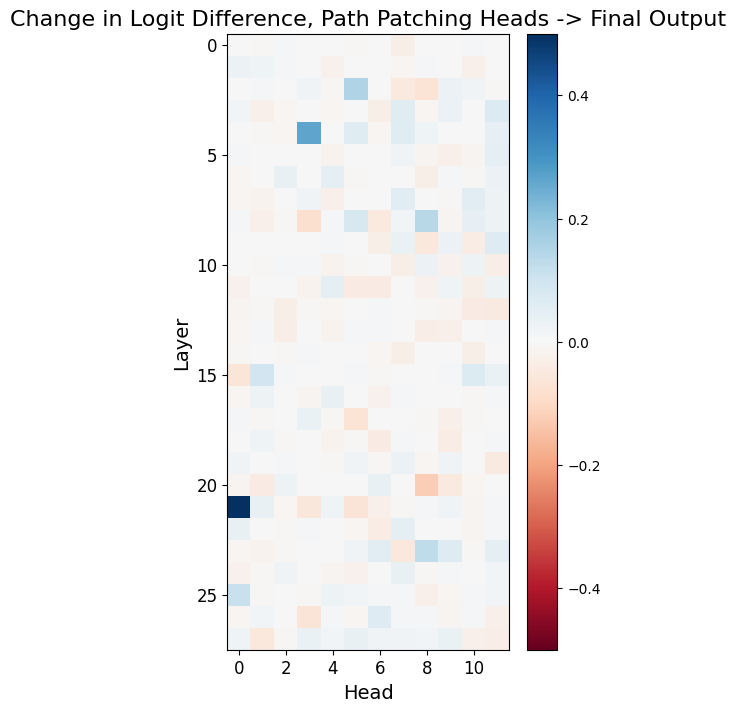

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))

# Plot heat map with x being the head and y being the layer

ax1 = fig.add_subplot(121)
ax1.set_title("Change in Logit Difference, Path Patching Heads -> Final Output", fontsize=16)
ax1.set_xlabel("Head", fontsize=14)
ax1.set_ylabel("Layer", fontsize=14)
# Set xtick size
plt.xticks(fontsize=12)
# Set ytick size
plt.yticks(fontsize=12)
# Add colormap
cbar = plt.colorbar(ax1.imshow(attn_head_scores, aspect='auto', cmap='RdBu', vmin=-0.5, vmax=0.5))
# Colormap label
# cbar.set_label('Logit Difference', rotation=90, labelpad=20, fontsize=14)
plt.show()

In [16]:
rand_toks.shape

torch.Size([839, 19])

In [17]:
from functools import partial
torch.cuda.empty_cache()
gc.collect()

batch_size = 50
noise_mlp_enrichment_results = []
for i in tqdm(range(0, len(prompt_toks), batch_size)):
    torch.cuda.empty_cache()
    gc.collect()
    noise_mlp_enrichment_results.append( 
        torch.stack(
            path_patch(
                model,
                orig_input=rand_toks[i:i+batch_size],
                new_input=prompt_toks[i:i+batch_size],
                sender_nodes=IterNode('mlp_out'),
                receiver_nodes=Node('resid_pre', layer=20),
                patching_metric=partial(denoising_metric, start_idx=i, end_idx=i+batch_size),
                direct_includes_mlps=False,
                verbose=True,
            )['mlp_out']
        )
    )
noise_mlp_enrichment_results = torch.cat(noise_mlp_enrichment_results, dim=-1)  # cat over batch dim

  6%|▌         | 1/17 [00:13<03:42, 13.91s/it]

results['mlp_out'].shape = (layer=28)


 12%|█▏        | 2/17 [00:27<03:28, 13.90s/it]

results['mlp_out'].shape = (layer=28)


 18%|█▊        | 3/17 [00:41<03:15, 13.97s/it]

results['mlp_out'].shape = (layer=28)


 24%|██▎       | 4/17 [00:56<03:03, 14.10s/it]

results['mlp_out'].shape = (layer=28)


 29%|██▉       | 5/17 [01:10<02:50, 14.18s/it]

results['mlp_out'].shape = (layer=28)


 35%|███▌      | 6/17 [01:24<02:35, 14.15s/it]

results['mlp_out'].shape = (layer=28)


 41%|████      | 7/17 [01:38<02:21, 14.16s/it]

results['mlp_out'].shape = (layer=28)


 47%|████▋     | 8/17 [01:53<02:08, 14.22s/it]

results['mlp_out'].shape = (layer=28)


 53%|█████▎    | 9/17 [02:07<01:53, 14.22s/it]

results['mlp_out'].shape = (layer=28)


 59%|█████▉    | 10/17 [02:21<01:39, 14.25s/it]

results['mlp_out'].shape = (layer=28)


 65%|██████▍   | 11/17 [02:36<01:25, 14.29s/it]

results['mlp_out'].shape = (layer=28)


 71%|███████   | 12/17 [02:50<01:11, 14.34s/it]

results['mlp_out'].shape = (layer=28)


 76%|███████▋  | 13/17 [03:04<00:57, 14.36s/it]

results['mlp_out'].shape = (layer=28)


 82%|████████▏ | 14/17 [03:19<00:43, 14.38s/it]

results['mlp_out'].shape = (layer=28)


 88%|████████▊ | 15/17 [03:33<00:28, 14.32s/it]

results['mlp_out'].shape = (layer=28)


 94%|█████████▍| 16/17 [03:47<00:14, 14.36s/it]

results['mlp_out'].shape = (layer=28)


100%|██████████| 17/17 [03:59<00:00, 14.10s/it]

results['mlp_out'].shape = (layer=28)


In [18]:
mlp_scores = np.array(noise_mlp_enrichment_results)
mlp_scores.shape

(28, 839)

In [16]:
plt.hist(mlp_scores[:, 1])

NameError: name 'mlp_scores' is not defined

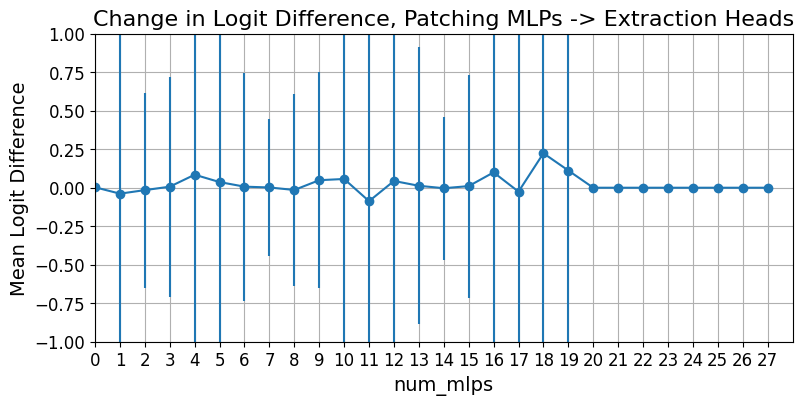

In [37]:
mean_scores = np.mean(mlp_scores, axis=1)
std_scores = np.std(mlp_scores, axis=1)

fig = plt.figure(figsize=(9, 4))
plt.errorbar(range(len(mean_scores)), mean_scores, yerr=std_scores, marker='o')
ax = plt.gca()
ax.set_title("Change in Logit Difference, Patching MLPs -> Extraction Heads", fontsize=16)
ax.set_xlabel("num_mlps", fontsize=14)
ax.set_ylabel("Mean Logit Difference", fontsize=14)
ax.set_xlim(0, len(mean_scores))
ax.set_ylim(-1, 1)
plt.grid()
plt.xticks(range(len(mean_scores)), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [19]:
# Bool tensor of shape (num_mlps, num_examples)
mlp_localizations = (abs(mlp_scores) > 2 * mlp_scores.std(0, keepdims=True)).astype(np.uint32)

# Turn this into a list of strings by concatenating the integers
mlp_localizations_str = np.array(["".join(str(x) for x in mlp_localizations[:, i]) for i in range(mlp_localizations.shape[1])])

In [27]:
# Save as csv
df = cfact['train'].to_pandas()
df['localization_str'] = mlp_localizations_str
df.to_csv(f"~/mechanistic-unlearning/experiments/scaling_counterfact/cfact_forget_{MODEL_NAME.replace('/', '_')}.csv", index=False)

In [22]:
model.tokenizer.batch_decode(prompt_toks[mlp_localizations_str == "0000001000000000000000000000"])

['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>The original language of The Icelandic Dream was',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Tapio Kantanen is a citizen of',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Kuala Langat, located in',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Hohenlohe-Langenburg is located in the country of',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>The language of Dehkhoda Dictionary is',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Omar Torrijos died in the city

In [42]:
cfact["test"]["correct_token"]

[10174,
 26937,
 83520,
 8330,
 5085,
 26278,
 26549,
 14811,
 7148,
 27602,
 19761,
 26198,
 21718,
 79622,
 8585,
 19440,
 31086,
 58692,
 10557,
 9625,
 12089,
 23968,
 6364,
 40970,
 23947,
 8257,
 49321,
 26194,
 18657,
 85445,
 18925,
 24029,
 38501,
 31503,
 10557,
 21273,
 26198,
 7148,
 22799,
 54375,
 8585,
 7148,
 57858,
 37741,
 26278,
 26953,
 22652,
 8585,
 8585,
 8162,
 10196,
 11470,
 8330,
 39450,
 23219,
 15948,
 43783,
 71687,
 14811,
 6323,
 6747,
 36266,
 50462,
 63272,
 8585,
 81810,
 37596,
 27810,
 22415,
 45753,
 19481,
 26194,
 42377,
 80685,
 7148,
 8585,
 16355,
 6864,
 4505,
 10557,
 22652,
 39450,
 6364,
 8585,
 33897,
 12095,
 55650,
 53142,
 24029,
 8585,
 57853,
 6747,
 71132,
 16986,
 25296,
 8162,
 6364,
 15948,
 15154,
 8585,
 63935,
 83876,
 30109,
 5100,
 24029,
 8585,
 40306,
 55650,
 16986,
 50021,
 16986,
 14632,
 7148,
 27922,
 53368,
 8330,
 18657,
 27521,
 43967,
 16355,
 58125,
 15948,
 19507,
 43967,
 8162,
 33897,
 31064,
 14910,
 12089,
 

# Evaluations

In [121]:
# MCQ Prompts
import pandas as pd

mc_question_format = f"""Help me answer the following multiple choice question:\n\n{{question}}\n\nA. {{response_a}}\nB. {{response_b}}\nC. {{response_c}}\nD. {{response_d}}\n\nPlease respond with the letter of the correct answer, A, B, C, or D. Answer:"""
counterfact_mc_df = pd.read_parquet("tasks/facts/data/counterfact_mc_questions.parquet").rename({"target_true": "target_true_mc", "targets_false": "targets_false_mc", "question": "question_mc"}, axis=1)

In [ ]:
# Paraphrased prompts
# Neighborhood prompts
# Latent probe accuracies

In [ ]:
# Relearning?